# Chapter 2: Price prediction: Linear Regression

Main goal: 

+ Implement a car price recommendation given some characteristics of them (feautures). The output will be the suggested car price (target variable).
+ Numerical variable: linear regression.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')

## 1. Reading and preparing data.

In [3]:
df = pd.read_csv("data.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


We see some white spaces and there are data in lower/upper case. Let's fix it:

In [4]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

string_columns = list(df.dtypes[df.dtypes == "object"].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")
    
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


## 2. Exploratory data analysis

We need to know what kind of data we have. It is necessary to learn:

  1. The distribution of the target variable.
  2. The features of the dataset.
  3. The distribution of values in these features.
  4. The quality of the data.
  5. The number of missing values.

### 2.1. Target variable

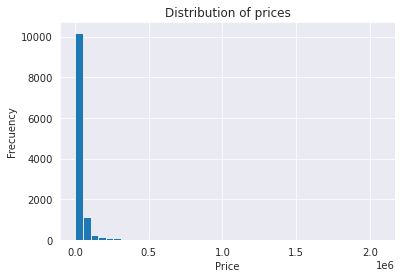

In [7]:
plt.figure(figsize = (6,4))

sns.histplot(df.msrp, bins = 40, alpha = 1)
plt.title("Distribution of prices")
plt.xlabel("Price")
plt.ylabel("Frecuency")

plt.show()

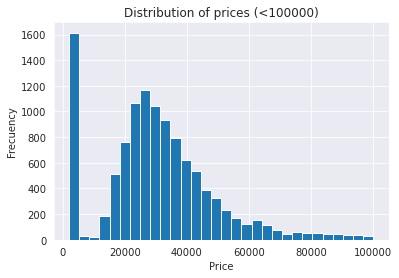

In [15]:
plt.figure(figsize = (6,4))

sns.histplot(df.msrp[df.msrp < 100000], bins = 30, alpha = 1)
plt.xlabel("Price")
plt.ylabel("Frecuency")
plt.title("Distribution of prices (<100000)")

plt.show()

+ As we can see, there is a long tail in the data. It means there are many cars with low price and few with high price.

+ Such distribution will confuse the model, so it won't learn well enough. One way to solve this problem is applying a log transformation.

+ Generally, it is good when the target variable looks like the normal distribution.

+ Log(x+1) avoids an issue with a zero. Also we will make sure all prices are not below zero.

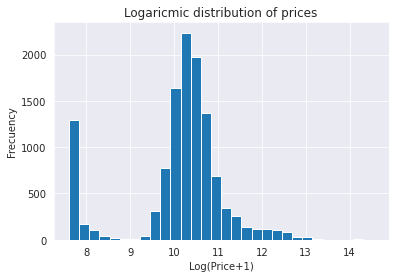

In [16]:
log_price = np.log1p(df.msrp)

plt.figure(figsize = (6,4))

sns.histplot(log_price, bins = 30, alpha = 1)
plt.xlabel("Log(Price+1)")
plt.ylabel("Frecuency")
plt.title("Logaricmic distribution of prices")

plt.show()

### 2.2. Checking for missing values

+ Machine learning algorithms cannot deal with missing values.
+ A good result is that there is not mising values for our target variable.
+ There are some features with many missing values. We will deal with it later when we train the model so we should keep this problem in mind.

In [7]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## 3. Validation framework

We need to split the dataset into three parts: train, validation and test sets:

In [6]:
df_train_full, df_test = train_test_split(df, test_size = 0.2, random_state = 11)

df_train, df_val = train_test_split(df_train_full, test_size = 0.33, random_state  = 2)

In [7]:
Y_train_orig = df_train.msrp.values
Y_val_orig = df_val.msrp.values
Y_test_orig = df_test.msrp.values

Y_train = np.log1p(df_train.msrp.values)
Y_val = np.log1p(df_val.msrp.values)
Y_test = np.log1p(df_test.msrp.values)

Removing the target variable is an optional step. But it is helful to make sure that we don't use it when training a model.

In [8]:
del df_train["msrp"]
del df_val["msrp"]
del df_test["msrp"]

## 4. Baseline solution (Test I)

Let's select some features and prepare our corresponding matrixes for feedding our model. These features are numerical.

In [11]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

In [9]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

In [10]:
def prepare_X(df_received):
    df_base = df_received[base]
    X = df_base.fillna(0).values
    return X

In [11]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

### 4.1. Linear Regression 

In [12]:
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_val)

In [13]:
RMSE = mean_squared_error(Y_val, Y_pred, squared = False)
print("RMSE: {}".format(RMSE))

RMSE: 0.7631807894739401


The goal is to minimize the MSE as much as possible (mean squared error): mwtric that quantifies the quality of the model.

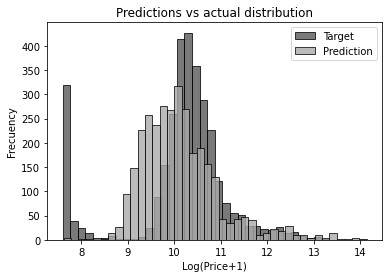

In [17]:
plt.figure(figsize = (6,4))

sns.histplot(Y_val, bins = 40, alpha = 0.6, color = "#222222", label = "Target" )
sns.histplot(Y_pred, bins = 40, alpha = 0.8, color = "#aaaaaa", label = "Prediction" )

plt.xlabel("Log(Price+1)")
plt.ylabel("Frecuency")
plt.title("Predictions vs actual distribution")
plt.legend(loc = "best")

plt.show()

## 5. Simple feature engineering (Test II)

The feature engineering consists of adding/creating new features for improving the model performance.

### 5.1. Adding a numerical variable

In [14]:
def prepare_X(df_received):
    df = df_received.copy()
    features = base.copy()
    
    df["age"] = df.year.max() - df.year
    features.append("age")
    
    df_features = df[features]
    X = df_features.fillna(0).values
    
    return X    

In [15]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

In [16]:
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_val)

In [17]:
RMSE = mean_squared_error(Y_val, Y_pred, squared = False)
print("RMSE: {}".format(RMSE))

RMSE: 0.5132590129759806


Adding the feature age we can conclude the model performance has improved.

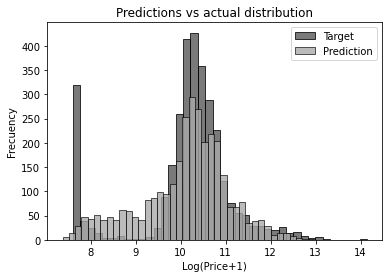

In [22]:
plt.figure(figsize = (6,4))

sns.histplot(Y_val, bins = 40, alpha = 0.6, color = "#222222", label = "Target" )
sns.histplot(Y_pred, bins = 40, alpha = 0.8, color = "#aaaaaa", label = "Prediction" )

plt.xlabel("Log(Price+1)")
plt.ylabel("Frecuency")
plt.title("Predictions vs actual distribution")
plt.legend(loc = "best")

plt.show()

### 5.2. Adding categorical variables

+ Apparently, the number os doors could be a numerical variable, but it can take only a few values: 2,3 and 4. Therefore, we conclude it is a categorical variable.

+ The procedure is the following: apply "one hot encoding for every categorical variable we want to add.

In [23]:
df.number_of_doors.value_counts()

4.0    8353
2.0    3160
3.0     395
Name: number_of_doors, dtype: int64

In [24]:
df["make"].value_counts().head(5)

chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
Name: make, dtype: int64

In [18]:
def prepare_X(df_received):
    df = df_received.copy()
    features = base.copy()
    
    #Adding age feature
    
    df["age"] = df.year.max() - df.year
    features.append("age")
    
    #Adding num_doors feature
    
    for var in [2, 3, 4]:
        feature = "num_doors_%s" % var
        df[feature] = (df["number_of_doors"] == var).astype(int)
        features.append(feature)
    
    #Adding make feature
    
    for var in ["chevrolet", "ford", "volkswagen", "toyota", "dodge"]:
        feature = "is_make_%s" % var
        df[feature] = (df["make"] == var).astype(int)
        features.append(feature)
    
    
    df_features = df[features]
    X = df_features.fillna(0).values
    
    return X

In [19]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

In [20]:
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_val)

In [21]:
RMSE = mean_squared_error(Y_val, Y_pred, squared = False)
print("RMSE: {}".format(RMSE))

RMSE: 0.5004552592515428


In [42]:
df["engine_fuel_type"].value_counts()

regular_unleaded                                7172
premium_unleaded_(required)                     2009
premium_unleaded_(recommended)                  1523
flex-fuel_(unleaded/e85)                         899
diesel                                           154
electric                                          66
flex-fuel_(premium_unleaded_required/e85)         54
flex-fuel_(premium_unleaded_recommended/e85)      26
flex-fuel_(unleaded/natural_gas)                   6
natural_gas                                        2
Name: engine_fuel_type, dtype: int64

In [22]:
def prepare_X(df_received):
    df = df_received.copy()
    features = base.copy()
    
    #Adding age feature
    
    df["age"] = df.year.max() - df.year
    features.append("age")
    
    #Adding num_dors feature
    
    for var in [2, 3, 4]:
        feature = "num_doors_%s" % var
        df[feature] = (df["number_of_doors"] == var).astype(int)
        features.append(feature)
        
    #Adding make feature
    
    for v in ["chevrolet", "ford", "volkswagen", "toyota", "dodge"]:
        feature = "is_make_%s" % v
        df[feature] = (df["make"] == v).astype(int)
        features.append(feature)
        
    #Adding engine_fuel_type feature

    for v in ["regular_unleaded", "premium_unleaded_(required)", 
              "premium_unleaded_(recommended)", "flex-fuel_(unleaded/e85)"]:
        feature = "is_type_%s" % v
        df[feature] = (df["engine_fuel_type"] == v).astype(int)
        features.append(feature)
  

    df_features = df[features]
    X = df_features.fillna(0).values
    
    return X

In [23]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

In [24]:
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_val)

In [25]:
RMSE = mean_squared_error(Y_val, Y_pred, squared = False)
print("RMSE: {}".format(RMSE))

RMSE: 0.47007964255628654


In [34]:
df["driven_wheels"].value_counts()

front_wheel_drive    4787
rear_wheel_drive     3371
all_wheel_drive      2353
four_wheel_drive     1403
Name: driven_wheels, dtype: int64

In [35]:
df["market_category"].value_counts().head(5)

crossover             1110
flex_fuel              872
luxury                 855
luxury,performance     673
hatchback              641
Name: market_category, dtype: int64

In [36]:
df["vehicle_size"].value_counts().head(5)

compact    4764
midsize    4373
large      2777
Name: vehicle_size, dtype: int64

In [37]:
df["vehicle_style"].value_counts().head(5)

sedan            3048
4dr_suv          2488
coupe            1211
convertible       793
4dr_hatchback     702
Name: vehicle_style, dtype: int64

In [43]:
def prepare_X(df_received):
    df = df_received.copy()
    features = base.copy()
    
    #Adding age feature

    df["age"] = df.year.max() - df.year
    features.append("age")
    
    #Adding num_dors feature
    
    for var in [2, 3, 4]:
        feature = "num_doors_%s" % var
        df[feature] = (df["number_of_doors"] == var).astype(int)
        features.append(feature)
        
    #Adding make feature
    
    for var in ["chevrolet", "ford", "volkswagen", "toyota", "dodge"]:
        feature = "is_make_%s" % var
        df[feature] = (df["make"] == var).astype(int)
        features.append(feature)
        
    #Adding engine_fuel_type feature

    for var in ["regular_unleaded", "premium_unleaded_(required)", 
              "premium_unleaded_(recommended)", "flex-fuel_(unleaded/e85)"]:
        feature = "is_type_%s" % var
        df[feature] = (df["engine_fuel_type"] == var).astype(int)
        features.append(feature)
        
    #Adding feature

    for var in ["automatic", "manual", "automated_manual"]:
        feature = "is_transmission_%s" % var
        df[feature] = (df["transmission_type"] == var).astype(int)
        features.append(feature)
        
    #Adding driven_wheels feature

    for var in ["front_wheel_drive", "rear_wheel_drive", "all_wheel_drive", "four_wheel_drive"]:
        feature = "is_driven_wheens_%s" % var
        df[feature] = (df["driven_wheels"] == var).astype(int)
        features.append(feature)
        
    #Adding market category feature

    for var in ["crossover", "flex_fuel", "luxury", "luxury,performance", "hatchback"]:
        feature = "is_mc_%s" % var
        df[feature] = (df["market_category"] == var).astype(int)
        features.append(feature)
        
    #Adding vehicle_size feature

    for var in ["compact", "midsize", "large"]:
        feature = "is_size_%s" % var
        df[feature] = (df["vehicle_size"] == var).astype(int)
        features.append(feature)
    
    #Adding vehicle_style feature

    for var in ["sedan", "4dr_suv", "coupe", "convertible", "4dr_hatchback"]:
        feature = "is_style_%s" % var
        df[feature] = (df["vehicle_style"] == var).astype(int)
        features.append(feature)

    df_features = df[features]
    X = df_features.fillna(0).values
    
    return X

In [27]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

In [28]:
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_val)

In [29]:
RMSE = mean_squared_error(Y_val, Y_pred, squared = False)
print("RMSE: {}".format(RMSE))

RMSE: 0.46025728088151563


Adding more and more features is not always the best choice. In our model the MSE is getting lower when we have added more features but sometimes it does not work.

## 6. Regularization

Now, we are going to apply a linear regression with Ridge regularization to solve the numerical instability (maybe some series are a combination of others or the data is noisy). 

In [32]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

In [34]:
model = Ridge()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_val)

In [35]:
RMSE = mean_squared_error(Y_val, Y_pred, squared = False)
print("RMSE: {}".format(RMSE))

RMSE: 0.4597703006140645


## 7. Using the model

In [37]:
print("NUMBER OF CARS IN THE DATASET: {}".format(len(df)))

NUMBER OF CARS IN THE DATASET: 11914


In [55]:
car_selected = 456

car = df_test.iloc[car_selected].to_dict()
car

{'make': 'volkswagen',
 'model': 'golf',
 'year': 2015,
 'engine_fuel_type': 'diesel',
 'engine_hp': 150.0,
 'engine_cylinders': 4.0,
 'transmission_type': 'manual',
 'driven_wheels': 'front_wheel_drive',
 'number_of_doors': 4.0,
 'market_category': 'hatchback,diesel',
 'vehicle_size': 'compact',
 'vehicle_style': '4dr_hatchback',
 'highway_mpg': 45,
 'city_mpg': 30,
 'popularity': 873}

In [56]:
df_car = pd.DataFrame([car])

X = prepare_X(df_car)
Y_pred = model.predict(X)

suggestion = np.expm1(Y_pred)
print("Suggested price: {}".format(suggestion))

Suggested price: [35247.7270379]
